# Stopword Removal from Media Unit & Annotation

In this tutorial, we will show how *dimensionality reduction* can be applied over *both the media units and the annotations* of a crowdsourcing task, and how this impacts the results of the CrowdTruth quality metrics. We start with an *open-ended extraction task*, where the crowd was asked to highlight words or phrases in a text that identify or refer to people in a video. The task was executed on [FigureEight](https://www.figure-eight.com/). This is how the task looked like to the workers:

![Task Template](img/person-video-highlight.png)

A sample dataset for this task is available in [this file](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/data/person-video-highlight.csv), containing raw output from the crowd on FigureEight. Download the file and place it in a folder named `data` that has the same root as this notebook. The answers from the crowd are stored in the `taggedinsubtitles` column.

In [1]:
import pandas as pd

test_data = pd.read_csv("data/person-video-highlight.csv")
test_data["taggedinsubtitles"][0:30]

0            ["Italian","astronaut","samantha","she's"]
1                            ["astronaut","photograph"]
2                                         ["astronaut"]
3              ["astronaut","samantha","cristoforetti"]
4     ["Italian","astronaut","samantha","cristoforet...
5     ["Italian astronaut samantha cristoforetti upl...
6     ["Italian","astronaut","samantha cristoforetti...
7                ["astronaut","samantha cristoforetti"]
8     ["Italian","astronaut","samantha","cristoforet...
9     ["Italian","astronaut","samantha","cristoforet...
10    ["astronaut","samantha","cristoforetti","photo...
11       ["astronaut","samantha cristoforetti","she's"]
12    ["Italian","astronaut","samantha","cristoforet...
13                                        ["astronaut"]
14                 ["Italian","astronaut","photograph"]
15    ["Italian","astronaut","samantha","cristoforet...
16    ["Italian","astronaut","samantha","cristoforet...
17    ["Italian","astronaut","samantha","cristof

Notice the diverse behavior of the crowd workers. While most annotated each word individually, the worker on *row 5* annotated chunks of the sentence together in one word phrase. Also, when no answer was picked by the worker, the value in the cell is `NaN`.

## A basic pre-processing configuration

Our basic pre-processing configuration attempts to normalize the different ways of performing the crowd annotations.

We set `remove_empty_rows = False` to keep the empty rows from the crowd. This configuration option will set all empty cell values to correspond to a *NONE* token in the annotation vector.

We build the annotation vector to have one component for each word in the sentence. To do this, we break up multiple-word annotations into a list of single words in the `processJudgments` call:

```
judgments[self.outputColumns[0]] = judgments[self.outputColumns[0]].apply(lambda x: str(x).replace(
            ' ',self.annotation_separator))
```

The final configuration class `Config` is this:

In [2]:
import crowdtruth
from crowdtruth.configuration import DefaultConfig

class Config(DefaultConfig):
    inputColumns = ["ctunitid", "videolocation", "subtitles"]
    outputColumns = ["taggedinsubtitles"]
    open_ended_task = True
    annotation_separator = ","

    remove_empty_rows = False
    
    def processJudgments(self, judgments):
        # build annotation vector just from words
        judgments[self.outputColumns[0]] = judgments[self.outputColumns[0]].apply(lambda x: str(x).replace(
            ' ',self.annotation_separator))

        # normalize vector elements
        judgments[self.outputColumns[0]] = judgments[self.outputColumns[0]].apply(lambda x: str(x).replace('[',''))
        judgments[self.outputColumns[0]] = judgments[self.outputColumns[0]].apply(lambda x: str(x).replace(']',''))
        judgments[self.outputColumns[0]] = judgments[self.outputColumns[0]].apply(lambda x: str(x).replace('"',''))
        return judgments

Now we can pre-process the data and run the CrowdTruth metrics:

In [3]:
data_with_stopwords, config_with_stopwords = crowdtruth.load(
    file = "data/person-video-highlight.csv",
    config = Config()
)

processed_results_with_stopwords = crowdtruth.run(data_with_stopwords, config_with_stopwords)

## Removing stopwords from Units and Annotations

The function that removes stopwords from strings:

In [4]:
import nltk
from nltk.corpus import stopwords
import string

stopword_set = set(stopwords.words('english'))
stopword_set.update(['s'])

def remove_stop_words(all_words, sep):
    words_list = all_words.replace("'", sep).split(sep)
    corrected_words_list = ""
    for word in words_list:
        if word.translate(None, string.punctuation) not in stopword_set:
            if corrected_words_list != "":
                corrected_words_list += sep
            corrected_words_list += word
    return corrected_words_list

The final configuration class:

In [5]:
import pandas as pd

class ConfigDimRed(Config):
    def processJudgments(self, judgments):
        judgments = Config.processJudgments(self, judgments)
        
        # remove stopwords from input sentence
        for idx in range(len(judgments[self.inputColumns[2]])):
            judgments.at[idx, self.inputColumns[2]] = remove_stop_words(
                judgments[self.inputColumns[2]][idx], " ")
        
        for idx in range(len(judgments[self.outputColumns[0]])):
            judgments.at[idx, self.outputColumns[0]] = remove_stop_words(
                judgments[self.outputColumns[0]][idx], self.annotation_separator)
            if judgments[self.outputColumns[0]][idx] == "":
                judgments.at[idx, self.outputColumns[0]] = self.none_token
        return judgments

Now we can pre-process the data and run the CrowdTruth metrics:

In [5]:
data_without_stopwords, config_without_stopwords = crowdtruth.load(
    file = "data/person-video-highlight.csv",
    config = ConfigDimRed()
)

processed_results_without_stopwords = crowdtruth.run(data_without_stopwords, config_without_stopwords)

## Effect on CrowdTruth metrics

Finally, we can compare the effect of the stopword removal on the CrowdTruth quality metrics.

Text(0,0.5,'without stopwords')

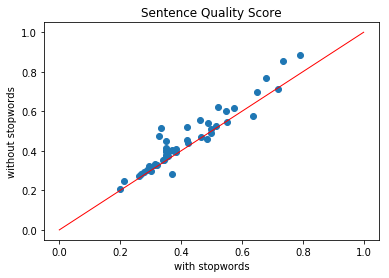

In [8]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.scatter(
    processed_results_with_stopwords["units"]["uqs"],
    processed_results_without_stopwords["units"]["uqs"],
)
plt.plot([0, 1], [0, 1], 'red', linewidth=1)
plt.title("Sentence Quality Score")
plt.xlabel("with stopwords")
plt.ylabel("without stopwords")

Text(0,0.5,'without stopwords')

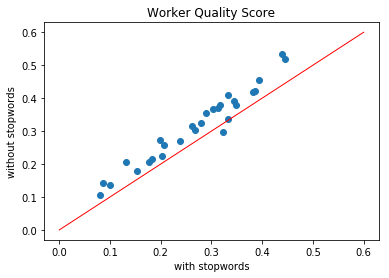

In [9]:
plt.scatter(
    processed_results_with_stopwords["workers"]["wqs"],
    processed_results_without_stopwords["workers"]["wqs"],
)
plt.plot([0, 0.6], [0, 0.6], 'red', linewidth=1)
plt.title("Worker Quality Score")
plt.xlabel("with stopwords")
plt.ylabel("without stopwords")